In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import models
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from transformers import AutoTokenizer, AutoModel, PatchTSTModel, PatchTSTConfig
import numpy as np


class ClasificadorDepresionResNet(nn.Module):
    def __init__(self,
                 freeze_image=True,
                 freeze_text=True,
                 freeze_patch=True,
                 text_model_name="distilbert-base-uncased",
                 max_length=256,
                 patchtst_config=None,
                 output_dim=1,
                 dropout_rate=0.5,
                 device="cpu"):

        super().__init__()
        self.device = device
        self.max_length = max_length

        print("Cargando ResNet18 pre-entrenada")
        weights = models.ResNet18_Weights.DEFAULT
        self.resnet_backbone = models.resnet18(weights=weights)

        if freeze_image:
          print("Congelando ResNet18")
          for param in self.resnet_backbone.parameters():
              param.requires_grad = False

        img_feat_dim = self.resnet_backbone.fc.in_features


        self.resnet_backbone.fc = nn.Identity()


        self.tokenizer = AutoTokenizer.from_pretrained(text_model_name)
        self.text_model = AutoModel.from_pretrained(text_model_name).to(device)
        text_feat_dim = 768  # DistilBERT

        if freeze_text:
          print("→ Congelando DistilBERT")
          for param in self.text_model.parameters():
              param.requires_grad = False

        self.patch_model = PatchTSTModel(patchtst_config).to(device)


        if freeze_patch:
          print("→ Congelando PatchTST")
          for param in self.patch_model.parameters():
              param.requires_grad = False



        num_patches = (patchtst_config.context_length - patchtst_config.patch_length) // patchtst_config.patch_stride + 1
        sensor_feat_dim = num_patches * patchtst_config.d_model

        self.num_patches = num_patches
        self.sensor_feat_dim = sensor_feat_dim

        fusion_dim = img_feat_dim + text_feat_dim*2 + sensor_feat_dim

        print(f"Dimensión total fusionada = {fusion_dim}")

        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, output_dim)
        )



    def encode_text(self, texts):
        """
        text: lista de strings de largo batch.
        output: [batch, 768]
        """
        encoded = self.tokenizer(
            texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=self.max_length
        ).to(self.device)

        outputs = self.text_model(**encoded)
        emb = outputs.last_hidden_state.mean(dim=1)
        return emb


    def encode_sensor(self, bpm_batch):
        """
        bpm_batch: lista de arrays numpy, uno por cada item del batch.
        Devuelve: [batch, sensor_feat_dim]
        """
        TARGET_LEN = self.patch_model.config.context_length
        batch_tensors = []

        for bpm_seq in bpm_batch:





            # 1) pad/cut
            if len(bpm_seq) < TARGET_LEN:
                pad_size = TARGET_LEN - len(bpm_seq)
                pad_val = 0
                bpm_fixed = np.concatenate([bpm_seq, np.full(pad_size, pad_val)])
            else:
                bpm_fixed = bpm_seq[:TARGET_LEN]

            bpm_tensor = torch.tensor(bpm_fixed, dtype=torch.float32)\
                              .unsqueeze(-1)   # -> [T, 1]
            batch_tensors.append(bpm_tensor)

        X = torch.stack(batch_tensors, dim=0).to(self.device)  # [B, T, 1]

        #print(f"[PatchTST] Entrada al modelo: {X.shape}")

        outputs = self.patch_model(X) # [B, num_patches, d_model]

        #print(f"[PatchTST] last_hidden_state = {outputs.last_hidden_state.shape}")


        flattened = outputs.last_hidden_state.flatten(start_dim=1)

        return flattened


    def forward(self, images, text_stat, text_struct, bpm_batch):
        """
        images:       [B, 3, H, W]
        text_stat:    lista de strings largo B
        text_struct:  lista de strings largo B
        bpm_batch:    lista de arrays numpy, cada uno con la serie BPM
        """

        # image
        img_features = self.resnet_backbone(images)    # [B, img_feat_dim]

        # text
        emb_stat = self.encode_text(text_stat)         # [B, 768]
        emb_struct = self.encode_text(text_struct)     # [B, 768]

        # numerical
        sensor_features = self.encode_sensor(bpm_batch)  # [B, sensor_feat_dim]

        # fusión
        fused = torch.cat([
            img_features,
            emb_stat,
            emb_struct,
            sensor_features
        ], dim=1)  # [B, fusion_dim]

        # classificator
        output = self.classifier(fused)

        return output, fused


    def descongelar_backbone(self):
        print("Descongelando ResNet")
        for param in self.resnet_backbone.parameters():
            param.requires_grad = True


### entonces max_lenght = 64


In [ ]:
# cargar dataset
#import drive
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
prev = "drive/MyDrive/"
path = "data_biometric/"
file = "heart_rate_full_dataset_with_images.csv"
df = pd.read_csv(prev + path + file)
df.head()

import ast

df["bpm_list"] = df["bpm_list"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


In [ ]:
from transformers import AutoTokenizer
temp_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


def max_token_length(texts):
    max_len = 0
    for t in texts:
        tokens = temp_tokenizer.encode(t, truncation=False)
        if len(tokens) > max_len:
            max_len = len(tokens)
    return max_len

max_len_stat = max_token_length(df["text_statistical"])
max_len_struct = max_token_length(df["text_structural"])

print("Máx tokens (estadístico):", max_len_stat)
print("Máx tokens (estructural):", max_len_struct)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Máx tokens (estadístico): 59
Máx tokens (estructural): 24


In [ ]:
transformaciones_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transformaciones_train = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(p=0.5),  # Espejo
    #transforms.RandomRotation(degrees=15),   # Rotar un poco
    #transforms.ColorJitter(brightness=0.1, contrast=0.1), # Variar luz levemente
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformaciones val
transformaciones_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os


class DepresionDatasetMultimodal(Dataset):
    def __init__(self, dataframe, root_dir="drive/MyDrive/", transform=None):
        self.df = dataframe
        self.root = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        row = self.df.iloc[idx]


        img_path = os.path.join(self.root, row["path_image_gaf"])
        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"[ERROR] Imagen no encontrada: {img_path}")
            raise

        if self.transform:
            image = self.transform(image)


        text_stat = row["text_statistical"]
        text_struct = row["text_structural"]


        bpm_list = row["bpm_list"]


        max_len = 1440



        bpm = torch.tensor(bpm_list, dtype=torch.float32)

        if bpm.shape[0] < max_len:
            # padding con ceros
            pad_len = max_len - bpm.shape[0]
            bpm = torch.cat([bpm, torch.zeros(pad_len)])
        else:
            # recortar si es demasiado largo
            bpm = bpm[:max_len]

        label_bool = row["S_Depresión"]
        label = torch.tensor(1.0 if label_bool else 0.0, dtype=torch.float32)

        return {
            "image": image,
            "text_stat": text_stat,
            "text_struct": text_struct,
            "bpm": bpm,
            "label": label
        }


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader


BATCH_SIZE = 16


stratify=df['S_Depresión']
train_df, val_df = train_test_split(
    df,
    test_size=0.25,
    random_state=42,
    stratify=df['S_Depresión']
)

print(f"Total imágenes: {len(df)}")
print(f"Entrenamiento: {len(train_df)} imágenes")
print(f"Validación:    {len(val_df)} imágenes")

# root_dir='..'
train_dataset = DepresionDatasetMultimodal(dataframe=train_df, root_dir='drive/MyDrive/', transform=transformaciones_resnet)
val_dataset = DepresionDatasetMultimodal(dataframe=val_df, root_dir='drive/MyDrive/', transform=transformaciones_resnet)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


batch = next(iter(train_loader))

imagenes_batch = batch["image"]
text_statistical = batch["text_stat"]
text_structural = batch["text_struct"]
bpm = batch["bpm"]
etiquetas_batch = batch["label"]
print(f"\nForma del batch de imágenes: {imagenes_batch.shape}")
# torch.Size([8, 3, 224, 224])
print(f"Forme del batch de texto estadistico: {len(text_statistical)}")
# torch.Size([8,1,768])
print(f"Forma del batch de texto estructural: {len(text_structural)}")
# torch.Size([8,1,768])
print(f"Forma del batch de bpm: {bpm.shape}")
# torch.Size([8, 1440])

print(f"Forma del batch de etiquetas: {etiquetas_batch.shape}")
# torch.Size([8])



Total imágenes: 106
Entrenamiento: 79 imágenes
Validación:    27 imágenes

Forma del batch de imágenes: torch.Size([16, 3, 224, 224])
Forme del batch de texto estadistico: 16
Forma del batch de texto estructural: 16
Forma del batch de bpm: torch.Size([16, 1440])
Forma del batch de etiquetas: torch.Size([16])


In [ ]:
def entrenar_modelo(
    modelo,
    train_loader,
    val_loader,
    epochs=10,
    lr_resnet=1e-5,
    lr_text=2e-5,
    lr_patch=3e-5,
    lr_classifier=1e-4,
    weight_decay=1e-2
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Iniciando entrenamiento en: {device}")
    modelo.to(device)


    num_s = (train_df['S_Depresión'] == 0).sum()
    num_d = (train_df['S_Depresión'] == 1).sum()
    peso_positivo = torch.tensor([num_s / num_d]).to(device)

    print(f"Peso clase 1 = {peso_positivo.item():.2f}")

    criterion = nn.BCEWithLogitsLoss(pos_weight=peso_positivo)

    param_groups = []

    if any(p.requires_grad for p in modelo.resnet_backbone.parameters()):
        param_groups.append({"params": modelo.resnet_backbone.parameters(), "lr": lr_resnet})

    if any(p.requires_grad for p in modelo.text_model.parameters()):
        param_groups.append({"params": modelo.text_model.parameters(), "lr": lr_text})

    if any(p.requires_grad for p in modelo.patch_model.parameters()):
        param_groups.append({"params": modelo.patch_model.parameters(), "lr": lr_patch})

    if any(p.requires_grad for p in modelo.classifier.parameters()):
        param_groups.append({"params": modelo.classifier.parameters(), "lr": lr_classifier})

    print(f"Grupos de parámetros activos: {len(param_groups)}")

    optimizer = optim.AdamW(param_groups, weight_decay=weight_decay)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.1, patience=5
    )

    historial = {"train_loss": [], "val_acc": [], "val_loss": []}


    for epoch in range(epochs):
        inicio = time.time()
        modelo.train()
        running_loss = 0.0

        for batch in train_loader:
            images = batch["image"].to(device)
            text_stat = batch["text_stat"]
            text_struct = batch["text_struct"]
            bpm = batch["bpm"]
            labels = batch["label"].to(device).unsqueeze(1)

            optimizer.zero_grad()

            outputs, _ = modelo(images, text_stat, text_struct, bpm)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        val_acc, val_loss = evaluar(modelo, val_loader, criterion, device)
        scheduler.step(val_loss)

        historial["train_loss"].append(epoch_loss)
        historial["val_acc"].append(val_acc)
        historial["val_loss"].append(val_loss)

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Loss: {epoch_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | "
            f"Val Acc: {val_acc:.2%} | "
            f"Tiempo: {time.time()-inicio:.1f}s"
        )

    return modelo, historial


In [ ]:
def evaluar(modelo, loader, criterion, device):
    modelo.eval()
    correctos = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for batch in loader:

            images = batch["image"].to(device)
            text_stat = batch["text_stat"]
            text_struct = batch["text_struct"]
            bpm = batch["bpm"]
            labels = batch["label"].to(device).unsqueeze(1)

            outputs, _ = modelo(images, text_stat, text_struct, bpm)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            preds = (torch.sigmoid(outputs) > 0.5).float()
            correctos += (preds == labels).sum().item()
            total += labels.size(0)

    return correctos / total, running_loss / total


In [ ]:
patchtst_config = PatchTSTConfig(
    num_input_channels=1,
    context_length=1440,
    patch_length=240,        # ventana
    patch_stride=120,        # Overlap
    d_model=128,            # Dimensión de embeddings
    num_attention_heads=8,
    num_hidden_layers=4,
    dropout=0.0,
    prediction_length=0,
    num_targets=1
)

print(f"Configuración PatchTST:")
print(f"  - Context length: {patchtst_config.context_length}")
print(f"  - Patch length: {patchtst_config.patch_length}")
print(f"  - D_model: {patchtst_config.d_model}")
print(((patchtst_config.context_length - patchtst_config.patch_length) // patchtst_config.patch_stride + 1)*patchtst_config.d_model)

Configuración PatchTST:
  - Context length: 1440
  - Patch length: 240
  - D_model: 128
1408


In [ ]:
model = ClasificadorDepresionResNet(
    freeze_image=False,
    freeze_text=False,
    freeze_patch=False,
    dropout_rate=0.5,
    max_length=64,
    patchtst_config=patchtst_config,
    device=device
)
EPOCHS = 15
lr_imagem = 1e-7
lr_textm = 1e-7
lr_sensor = 1e-7
lr_classificator = 1e-7
print("Comenzando entrenamiento")
modelo_entrenado, historia = entrenar_modelo(model, train_loader, val_loader, epochs=EPOCHS,lr_resnet=lr_imagem, lr_text=lr_textm, lr_patch=lr_sensor, lr_classifier=lr_classificator)


y_true = []
y_pred = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# train eval
print("train eval")
modelo_entrenado.eval()
with torch.no_grad():
    for batch in train_loader:

        images = batch["image"].to(device)
        text_stat = batch["text_stat"]
        text_struct = batch["text_struct"]
        bpm = batch["bpm"]
        labels = batch["label"].to(device).unsqueeze(1)

        outputs, _ = modelo_entrenado(images, text_stat, text_struct, bpm)

        preds = (torch.sigmoid(outputs) > 0.5).float()

        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))
# val eval
print("val eval")
y_true = []
y_pred = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

modelo_entrenado.eval()
with torch.no_grad():
    for batch in val_loader:

        images = batch["image"].to(device)
        text_stat = batch["text_stat"]
        text_struct = batch["text_struct"]
        bpm = batch["bpm"]
        labels = batch["label"].to(device).unsqueeze(1)

        outputs, _ = modelo_entrenado(images, text_stat, text_struct, bpm)

        preds = (torch.sigmoid(outputs) > 0.5).float()

        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))


Cargando ResNet18 pre-entrenada
Dimensión total fusionada = 3456
Comenzando entrenamiento
Iniciando entrenamiento en: cuda
Peso clase 1 = 1.55
Grupos de parámetros activos: 4


/tmp/ipython-input-2902863543.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bpm_tensor = torch.tensor(bpm_fixed, dtype=torch.float32)\


Epoch 1/15 | Loss: 0.8429 | Val Loss: 0.8370 | Val Acc: 70.37% | Tiempo: 1.1s
Epoch 2/15 | Loss: 0.8342 | Val Loss: 0.8363 | Val Acc: 59.26% | Tiempo: 1.1s
Epoch 3/15 | Loss: 0.8371 | Val Loss: 0.8308 | Val Acc: 70.37% | Tiempo: 1.1s
Epoch 4/15 | Loss: 0.8445 | Val Loss: 0.8268 | Val Acc: 74.07% | Tiempo: 1.1s
Epoch 5/15 | Loss: 0.8578 | Val Loss: 0.8248 | Val Acc: 74.07% | Tiempo: 1.1s
Epoch 6/15 | Loss: 0.8455 | Val Loss: 0.8239 | Val Acc: 70.37% | Tiempo: 1.1s
Epoch 7/15 | Loss: 0.8513 | Val Loss: 0.8236 | Val Acc: 66.67% | Tiempo: 1.1s
Epoch 8/15 | Loss: 0.8513 | Val Loss: 0.8235 | Val Acc: 66.67% | Tiempo: 1.1s
Epoch 9/15 | Loss: 0.8453 | Val Loss: 0.8235 | Val Acc: 66.67% | Tiempo: 1.1s
Epoch 10/15 | Loss: 0.8439 | Val Loss: 0.8232 | Val Acc: 70.37% | Tiempo: 1.1s
Epoch 11/15 | Loss: 0.8376 | Val Loss: 0.8230 | Val Acc: 66.67% | Tiempo: 1.1s
Epoch 12/15 | Loss: 0.8426 | Val Loss: 0.8234 | Val Acc: 70.37% | Tiempo: 1.1s
Epoch 13/15 | Loss: 0.8427 | Val Loss: 0.8235 | Val Acc: 70.3

/tmp/ipython-input-2902863543.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bpm_tensor = torch.tensor(bpm_fixed, dtype=torch.float32)\


In [ ]:
y_true = []
y_pred = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

modelo_entrenado.eval()
with torch.no_grad():
    for batch in val_loader:

        images = batch["image"].to(device)
        text_stat = batch["text_stat"]
        text_struct = batch["text_struct"]
        bpm = batch["bpm"]
        labels = batch["label"].to(device).unsqueeze(1)

        outputs, _ = modelo_entrenado(images, text_stat, text_struct, bpm)

        preds = (torch.sigmoid(outputs) > 0.5).float()

        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))


              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67        16
         1.0       0.58      1.00      0.73        11

    accuracy                           0.70        27
   macro avg       0.79      0.75      0.70        27
weighted avg       0.83      0.70      0.69        27

[[ 8  8]
 [ 0 11]]


/tmp/ipython-input-2902863543.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bpm_tensor = torch.tensor(bpm_fixed, dtype=torch.float32)\


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

run_id = 11   # ID
PATH_VALORES = f"run_{run_id}_valores.csv"
PATH_METRICAS = f"run_{run_id}_metricas.csv"
PATH_MATRIZ_CONFUSION_NP = f"run_{run_id}_matriz_confusion.npy"
PATH_MATRIZ_CONFUSION_CSV = f"run_{run_id}_matriz_confusion.csv"



# 1. Guardar valores (y_true, y_pred)
df_vals = pd.DataFrame({
    "run_id": [run_id] * len(y_true),
    "instance": list(range(len(y_true))),
    "y_true": [int(x) for x in y_true],
    "y_pred": [int(x) for x in y_pred]
})

df_vals.to_csv(PATH_VALORES, index=False)


# 2. Guardar métricas
report_dict = classification_report(y_true, y_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
df_report["run_id"] = run_id

df_report.to_csv(PATH_METRICAS)
print(f"metricas guardadas en {PATH_METRICAS}")


# 3. Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cm)
df_cm.to_csv(PATH_MATRIZ_CONFUSION_CSV, index=False)

np.save(PATH_MATRIZ_CONFUSION_NP, cm)


print(f"\nTodo guardado correctamente para run_id={run_id}")


metricas guardadas en run_11_metricas.csv

Todo guardado correctamente para run_id=11


/tmp/ipython-input-819555157.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "y_true": [int(x) for x in y_true],
/tmp/ipython-input-819555157.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "y_pred": [int(x) for x in y_pred]


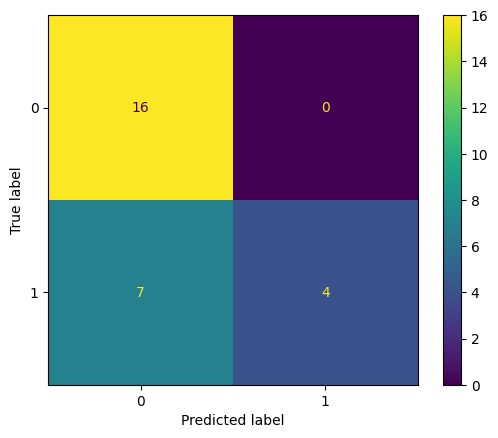

[[16  0]
 [ 7  4]]


In [ ]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels = [0, 1])
plt.show()
print(confusion_matrix(y_true, y_pred))

In [ ]:
PATH = f"modelo_multimodal_run_{run_id}.pth"
torch.save(model.state_dict(), PATH)
print("Modelo guardado en:", PATH)


Modelo guardado en: modelo_multimodal_run_3.pth


In [ ]:
from google.colab import files
#files.download(PATH)
files.download(PATH_VALORES)
files.download(PATH_METRICAS)
files.download(PATH_MATRIZ_CONFUSION_NP)
files.download(PATH_MATRIZ_CONFUSION_CSV)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>